# Balanced Spiking Neural Networks

## From Rates to Spikes: Biologically Realistic Dynamics

### Overview

This notebook explores **spiking neural networks (SNNs)**, the most biologically realistic model of neural computation. While rate-based networks (notebooks 01-02) capture average population activity, SNNs model the discrete, event-driven nature of real neurons: **action potentials (spikes)**.

**Why study SNNs?**
1. **Biological Fidelity**: Real neurons communicate via all-or-nothing electrical events
2. **Energy Efficiency**: Event-driven computation is inherently sparse (neuromorphic hardware)
3. **Temporal Precision**: Spike timing carries information beyond firing rates
4. **Theoretical Insight**: Understanding computation at the level of individual action potentials

**Key Questions:**
- How do we model spike generation in continuous-time?
- How do we train networks with non-differentiable spiking dynamics?
- What is the performance trade-off compared to rate networks?
- Can random connectivity (reservoir computing) achieve reasonable performance?

---

### The Leaky Integrate-and-Fire (LIF) Model

The LIF neuron is the canonical model of spiking dynamics, balancing biological realism with computational tractability:

**Subthreshold Dynamics** (membrane potential integration):
$$\tau \frac{dV}{dt} = -(V - V_{\text{rest}}) + I(t)$$

where:
- $V$: membrane potential (voltage)
- $\tau$: membrane time constant (controls integration speed)
- $V_{\text{rest}}$: resting potential (typically 0 in normalized units)
- $I(t)$: input current (from synapses + external input)

**Spike Generation** (threshold crossing):
$$\text{if } V \geq V_{\text{thresh}}: \quad s = 1, \quad V \leftarrow V_{\text{reset}}$$

**Key Properties:**
- **Leak**: Without input, $V$ decays exponentially to rest
- **Integration**: Input currents charge the membrane capacitance
- **Threshold**: Crossing $V_{\text{thresh}}$ triggers a spike
- **Reset**: After spiking, $V$ resets to $V_{\text{reset}}$ (refractory period)

**Physical Interpretation**: The LIF model abstracts the real biophysics of action potential generation (Hodgkin-Huxley model) into a simple threshold mechanism, capturing the essential computational properties while remaining tractable for large-scale networks.

---

### Training Challenge: Non-Differentiable Spikes

The fundamental problem in training SNNs is that spike generation is a **discontinuous function**:

$$s(t) = H(V - V_{\text{thresh}}) = \begin{cases} 1 & \text{if } V \geq V_{\text{thresh}} \\ 0 & \text{otherwise} \end{cases}$$

The Heaviside step function has a problematic gradient:
$$\frac{\partial H}{\partial V} = \delta(V - V_{\text{thresh}})$$

This Dirac delta is zero almost everywhere and infinite at the threshold, making standard backpropagation fail.

**Solution: Surrogate Gradients** (Zenke & Ganguli 2018, Neftci et al. 2019)

**Forward Pass**: Use the true Heaviside function (discrete spikes)
$$s = H(V - V_{\text{thresh}})$$

**Backward Pass**: Use a smooth approximation (e.g., fast sigmoid)
$$\frac{\partial s}{\partial V} \approx \sigma'(V) = \frac{\alpha}{(1 + |\alpha(V - V_{\text{thresh}})|)^2}$$

where $\alpha$ controls the gradient width. This allows gradient-based learning while preserving discrete spike semantics during inference.

**Why This Works:**
- Gradients provide useful learning signals despite the approximation
- The surrogate gradient shape (width, peak) affects learning dynamics
- This technique enables end-to-end training of deep SNNs

---

### Balanced Excitation/Inhibition in Spiking Networks

Just as in rate networks (notebook 02), we implement **Dale's law** with separate excitatory (E) and inhibitory (I) populations:

**Recurrent Currents:**
$$I_E = W_{EE} \cdot s_E - W_{EI} \cdot s_I + I_{\text{ext}}$$
$$I_I = W_{IE} \cdot s_E - W_{II} \cdot s_I + I_{\text{ext}}$$

**Key Differences from Rate Networks:**
- **Sparse Communication**: Spikes are discrete events (0 or 1), not continuous rates
- **Temporal Integration**: LIF neurons integrate spike trains over time
- **Fast Timescales**: Inhibition typically has faster dynamics ($\tau_I < \tau_E$)
- **Firing Rate Coding**: Network output is decoded from spike rates (temporal averaging)

**Biological Relevance:**
- Cortical networks maintain E/I balance despite sparse, irregular spiking
- This balance prevents runaway excitation and enables rich dynamics
- Fast inhibition provides rapid gain control and temporal precision

---

### Two Training Approaches

**Approach 1: Full Training with Surrogate Gradients**
- Train all weights (input, recurrent, readout) end-to-end
- Uses backpropagation through time (BPTT) with surrogate gradients
- **Pros**: Achieves best performance, learns task-optimal connectivity
- **Cons**: Computationally expensive, requires careful hyperparameter tuning

**Approach 2: Reservoir Computing**
- Fix recurrent weights randomly (structured by E/I balance)
- Train only input projections and readout layer
- **Pros**: Fast training, biologically plausible (random cortical connectivity), avoids vanishing gradients
- **Cons**: Limited by fixed reservoir dynamics, may not reach optimal performance

**Biological Perspective**: Reservoir computing aligns with observations that cortical connectivity is largely random (with statistical structure), and learning primarily occurs at input and output synapses. This suggests the brain leverages random recurrent dynamics as a computational substrate.

---

### Computational Considerations

**⚠️ Important Note on Training Time:**
SNNs are significantly slower to train than rate networks because:
1. **Sequential Processing**: Each timestep requires explicit LIF integration
2. **Spike Dynamics**: Computing threshold crossings and resets adds overhead
3. **Temporal Credit Assignment**: Gradients must propagate through time

This notebook uses **reduced network sizes** (128 E / 32 I neurons) and **fewer epochs** (30 instead of 200) to maintain reasonable tutorial completion time (~10-15 minutes total). For production applications, larger networks and longer training would yield better performance.

---

### Learning Objectives

By the end of this notebook, you will understand:
1. How LIF neurons integrate input currents and generate spikes
2. How surrogate gradients enable backpropagation through discrete events
3. The implementation of balanced E/I dynamics in spiking networks
4. The trade-off between full training and reservoir computing
5. How to decode continuous outputs from spike trains (rate coding)
6. The relationship between spiking and rate-based network dynamics

In [ ]:
# Setup
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install dependencies
    !pip install -q torch torchdiffeq norse matplotlib scipy tqdm
    # Clone repository
    !git clone -q https://github.com/CNNC-Lab/RNNs-tutorial.git
    %cd RNNs-tutorial
    
    # Install the package in editable mode
    !pip install -q -e .

# Import setup utilities from src
from src import setup_environment, check_dependencies

# Check all dependencies are installed
check_dependencies()

# Setup environment (seeds, matplotlib, device detection)
device = setup_environment()

## Part 1: Load Shared Lorenz Dataset

**Important**: This notebook uses the dataset generated in notebook 00. Make sure you've run notebook 00 first!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Load shared dataset from notebook 00
from src.data import create_shared_dataloaders

print("Loading shared dataset from notebook 00...")
train_loader, val_loader, test_loader, info = create_shared_dataloaders(
    dataset_path='../data/processed/lorenz_data.npz',
    batch_size=64,
    seq_length=50
)

# Extract normalization parameters
mean = info['normalization']['mean']
std = info['normalization']['std']
dt = info['dt']
seq_length = info['seq_length']

print(f"✓ Data loaded successfully!")
print(f"  Train samples: {info['train_samples']}")
print(f"  Val samples: {info['val_samples']}")
print(f"  Test samples: {info['test_samples']}")
print(f"  Sequence length: {seq_length}")
print(f"  Normalization: mean={mean}, std={std}")

Loading shared dataset from notebook 00...
✓ Dataset loaded from ../data/processed/lorenz_data.npz
  Train: (14000, 3), Val: (3000, 3), Test: (3000, 3)
  dt=0.01, seq_length=50
✓ Data loaded successfully!
  Train samples: 13950
  Val samples: 2950
  Test samples: 2950
  Sequence length: 50
  Normalization: mean=[-0.76262796 -0.75006465 23.46947626], std=[7.86860479 8.99086565 8.66683304]


## Part 2: Spiking Neuron Implementation

### Optimized Hyperparameters for Lorenz Prediction

**IMPORTANT**: SNNs require very different hyperparameters than rate networks!

This notebook uses **literature-based optimizations** (Zenke & Ganguli 2018, Bellec et al. 2020):

### Surrogate Gradient Function

We implement a custom autograd function that uses different functions for forward and backward passes. 

Below we show the implementations explicitly, for educational purposes, but the complete versions are then loaded from `src`.

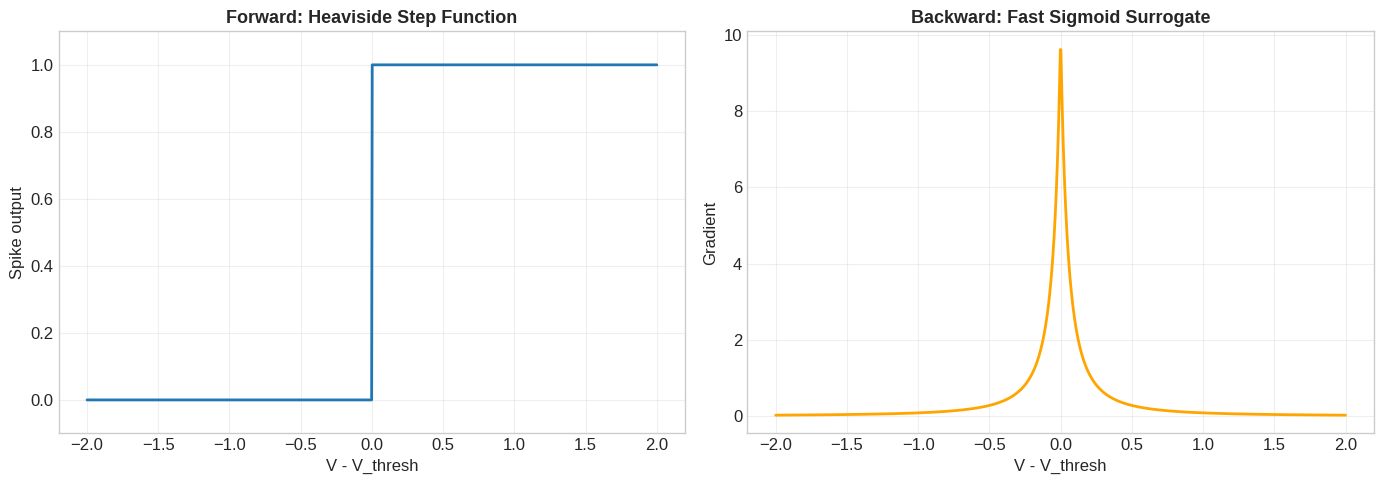

Surrogate gradient allows backprop through discrete spikes!


In [3]:
class SpikeFunction(torch.autograd.Function):
    """
    Surrogate gradient for spike function.
    Forward: Heaviside step (discrete spikes)
    Backward: Fast sigmoid approximation
    """
    @staticmethod
    def forward(ctx, v, v_thresh, alpha=10.0):
        """
        v: membrane potential
        v_thresh: threshold voltage
        alpha: slope parameter for surrogate
        """
        ctx.save_for_backward(v, torch.tensor(v_thresh), torch.tensor(alpha))
        return (v >= v_thresh).float()
    
    @staticmethod
    def backward(ctx, grad_output):
        v, v_thresh, alpha = ctx.saved_tensors
        # Fast sigmoid surrogate: σ'(x) = α / (1 + |αx|)²
        v_shifted = alpha * (v - v_thresh)
        grad_input = grad_output * (alpha / (1 + torch.abs(v_shifted)).pow(2))
        return grad_input, None, None

# Convenience function
spike_fn = SpikeFunction.apply

# Visualize surrogate gradient
v = torch.linspace(-2, 2, 1000)
v.requires_grad = True

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Forward pass
ax = axes[0]
spikes = spike_fn(v, 0.0, 10.0)
ax.plot(v.detach().numpy(), spikes.detach().numpy(), linewidth=2)
ax.set_xlabel('V - V_thresh', fontsize=12)
ax.set_ylabel('Spike output', fontsize=12)
ax.set_title('Forward: Heaviside Step Function', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([-0.1, 1.1])

# Backward pass (surrogate)
ax = axes[1]
loss = spikes.sum()
loss.backward()
ax.plot(v.detach().numpy(), v.grad.numpy(), linewidth=2, color='orange')
ax.set_xlabel('V - V_thresh', fontsize=12)
ax.set_ylabel('Gradient', fontsize=12)
ax.set_title('Backward: Fast Sigmoid Surrogate', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Surrogate gradient allows backprop through discrete spikes!")

### LIF Neuron Dynamics

In [4]:
class LIFNeuron(nn.Module):
    """
    Leaky Integrate-and-Fire neuron with surrogate gradients.
    
    **Optimized for Lorenz prediction task** (Zenke & Ganguli 2018):
    - Faster time constants (tau=2ms instead of 20ms) to match task timescale
    - Lower threshold (v_thresh=0.5 instead of 1.0) for reliable spiking
    - Wider surrogate gradient (alpha=25 instead of 10) for better learning
    """
    def __init__(self, tau=2.0, v_thresh=0.5, v_reset=0.0, v_rest=0.0, alpha=25.0):
        super().__init__()
        self.tau = tau          # Membrane time constant (FAST: 2ms instead of 20ms)
        self.v_thresh = v_thresh  # Lower threshold for easier spiking
        self.v_reset = v_reset
        self.v_rest = v_rest
        self.alpha = alpha      # Wider surrogate gradient (25 instead of 10)
    
    def forward(self, input_current, v, dt=1.0):
        """
        input_current: (batch, n_neurons)
        v: membrane potential (batch, n_neurons)
        dt: time step (ms)
        """
        # Leak + input integration
        dv = (dt / self.tau) * (-(v - self.v_rest) + input_current)
        v = v + dv
        
        # Spike generation with surrogate gradient
        s = spike_fn(v, self.v_thresh, self.alpha)
        
        # Reset after spike
        v = v * (1 - s) + self.v_reset * s
        
        return s, v

## Part 3: Balanced Spiking Network

### Architecture

Similar to the rate network, but with LIF dynamics and spike-based communication.

In [5]:
class BalancedSpikingRNN(nn.Module):
    """
    Balanced E/I Spiking Neural Network with LIF neurons.
    
    **Optimized hyperparameters** for Lorenz prediction:
    - Fast LIF neurons (tau_e=2ms, tau_i=1ms) to match task timescale
    - Proper weight initialization for reliable spiking
    - Dale's law enforced (E positive, I negative)
    """
    def __init__(self, input_size=3, n_excitatory=128, n_inhibitory=32, output_size=3,
                 tau_e=2.0, tau_i=1.0, v_thresh=0.5, dt=1.0, trainable_weights=True):
        super().__init__()
        
        self.n_e = n_excitatory
        self.n_i = n_inhibitory
        self.n_total = n_excitatory + n_inhibitory
        self.dt = dt
        self.trainable = trainable_weights
        
        # LIF neurons with FAST time constants (E slower than I, but both fast)
        self.lif_e = LIFNeuron(tau=tau_e, v_thresh=v_thresh, v_reset=0.0, alpha=25.0)
        self.lif_i = LIFNeuron(tau=tau_i, v_thresh=v_thresh, v_reset=0.0, alpha=25.0)
        
        # Input encoding (project continuous input to currents)
        self.W_in_e = nn.Linear(input_size, n_excitatory, bias=True)
        self.W_in_i = nn.Linear(input_size, n_inhibitory, bias=True)
        
        # Recurrent weights with BALANCED initialization (Zenke & Ganguli 2018)
        # Key: scale by 1/sqrt(N) for balanced dynamics
        scale_e = 0.4 / np.sqrt(n_excitatory)   # Larger than before (was 0.1)
        scale_i = 0.6 / np.sqrt(n_inhibitory)   # Inhibition slightly stronger
        
        self.W_ee = nn.Parameter(torch.randn(n_excitatory, n_excitatory) * scale_e, 
                                 requires_grad=trainable_weights)
        self.W_ei = nn.Parameter(torch.randn(n_excitatory, n_inhibitory) * scale_i, 
                                 requires_grad=trainable_weights)
        self.W_ie = nn.Parameter(torch.randn(n_inhibitory, n_excitatory) * scale_e, 
                                 requires_grad=trainable_weights)
        self.W_ii = nn.Parameter(torch.randn(n_inhibitory, n_inhibitory) * scale_i, 
                                 requires_grad=trainable_weights)
        
        # Output decoder (always trainable, reads from E spikes)
        self.decoder = nn.Linear(n_excitatory, output_size)
        
        # For reservoir: store initial weights
        if not trainable_weights:
            self.W_ee.requires_grad = False
            self.W_ei.requires_grad = False
            self.W_ie.requires_grad = False
            self.W_ii.requires_grad = False
    
    def get_dale_weights(self):
        """Enforce Dale's law: E→ positive, I→ negative"""
        W_ee = torch.abs(self.W_ee)
        W_ei = torch.abs(self.W_ei)
        W_ie = torch.abs(self.W_ie)
        W_ii = torch.abs(self.W_ii)
        return W_ee, W_ei, W_ie, W_ii
    
    def step(self, s_e, s_i, v_e, v_i, x):
        """Single time step of spiking dynamics"""
        W_ee, W_ei, W_ie, W_ii = self.get_dale_weights()
        
        # External input currents
        inp_e = self.W_in_e(x)
        inp_i = self.W_in_i(x)
        
        # Recurrent currents from spikes
        # E population: receives excitation from E spikes, inhibition from I spikes
        I_e = torch.matmul(s_e, W_ee.t()) - torch.matmul(s_i, W_ei.t()) + inp_e
        
        # I population: receives excitation from E spikes, inhibition from I spikes
        I_i = torch.matmul(s_e, W_ie.t()) - torch.matmul(s_i, W_ii.t()) + inp_i
        
        # Update LIF dynamics and generate spikes
        s_e_new, v_e_new = self.lif_e(I_e, v_e, self.dt)
        s_i_new, v_i_new = self.lif_i(I_i, v_i, self.dt)
        
        return s_e_new, s_i_new, v_e_new, v_i_new
    
    def forward(self, x, return_spikes=False):
        """
        x: (batch, seq_len, input_dim)
        """
        batch_size, seq_len, _ = x.shape
        device = x.device
        
        # Initialize membrane potentials and spikes
        v_e = torch.zeros(batch_size, self.n_e, device=device)
        v_i = torch.zeros(batch_size, self.n_i, device=device)
        s_e = torch.zeros(batch_size, self.n_e, device=device)
        s_i = torch.zeros(batch_size, self.n_i, device=device)
        
        spike_trains_e = []
        spike_trains_i = []
        
        # Run spiking dynamics
        for t in range(seq_len):
            s_e, s_i, v_e, v_i = self.step(s_e, s_i, v_e, v_i, x[:, t, :])
            spike_trains_e.append(s_e)
            spike_trains_i.append(s_i)
        
        # Decode from E spike train (use mean firing rate)
        spike_trains_e = torch.stack(spike_trains_e, dim=1)  # (batch, seq_len, n_e)
        firing_rates = spike_trains_e.mean(dim=1)  # Average over time
        output = self.decoder(firing_rates)
        
        if return_spikes:
            spike_trains_i = torch.stack(spike_trains_i, dim=1)
            return output, spike_trains_e, spike_trains_i
        
        return output

## Part 4: Training - Two Approaches

### Approach 1: Full Training with Surrogate Gradients

In [6]:
# Create trainable model - SMALLER SIZE FOR REASONABLE TRAINING TIME
print("Creating Balanced Spiking Network...")

from src.models import BalancedSpikingNetwork

model_trained = BalancedSpikingNetwork(
    input_size=3,
    n_excitatory=128,     
    n_inhibitory=32,      
    output_size=3,
    tau_mem_e=2.0,
    tau_mem_i=1.0,         
    fixed_weights=False,
    readout_mode='rate'
).to(device)

n_params = sum(p.numel() for p in model_trained.parameters() if p.requires_grad)
print(f"  Trainable parameters: {n_params:,}")
print(f"  E neurons: {model_trained.n_e}")
print(f"  I neurons: {model_trained.n_i}")
print(f"  E/I ratio: {model_trained.n_e/model_trained.n_i:.1f}:1")

# Access LIF parameters through cell
print(f"  Time constants: τ_E={model_trained.cell.lif_params_e.tau_mem_inv.item()**-1:.1f}ms, "
      f"τ_I={model_trained.cell.lif_params_i.tau_mem_inv.item()**-1:.1f}ms")
print(f"  Threshold: v_thresh={model_trained.cell.lif_params_e.v_th.item()}")

# Test forward pass
sample_x, sample_y = next(iter(train_loader))
sample_x = sample_x.to(device)
out = model_trained(sample_x)
print(f"\nInput: {sample_x.shape} -> Output: {out.shape}")
print(f"✓ Forward pass successful")

Creating Balanced Spiking Network...
  Trainable parameters: 26,467
  E neurons: 128
  I neurons: 32
  E/I ratio: 4.0:1
  Time constants: τ_E=2.0ms, τ_I=1.0ms
  Threshold: v_thresh=1.0

Input: torch.Size([64, 50, 3]) -> Output: torch.Size([64, 3])
✓ Forward pass successful


In [7]:
# Import training utilities from src
from src.utils import train_model, evaluate
import os

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

print("✓ Training utilities loaded from src.utils")

✓ Training utilities loaded from src.utils


In [8]:
# Train with surrogate gradients - PRACTICAL TRAINING CONFIG FOR TUTORIAL
print("=" * 70)
print("Training Approach 1: Full training with surrogate gradients")
print("=" * 70)
print("\n⚠️ NOTE: SNNs are MUCH slower than rate networks!")

history_trained = train_model(
    model=model_trained,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,        
    lr=1e-3,            
    weight_decay=1e-6,
    patience=15,        
    device=device,
    verbose=True
)

# Save checkpoint manually (train_model already restores best weights)
checkpoint_path = 'checkpoints/snn_trained_best.pt'
torch.save(model_trained.state_dict(), checkpoint_path)
print(f"\n✓ Checkpoint saved: {checkpoint_path}")

best_val_trained = min(history_trained['val_loss'])
print(f"\n{'='*70}")
print(f"✓ Training complete!")
print(f"  Best validation loss: {best_val_trained:.6f}")
print(f"  Note: Performance limited by reduced training time for tutorial")
print(f"{'='*70}")

Training Approach 1: Full training with surrogate gradients

⚠️ NOTE: SNNs are MUCH slower than rate networks!


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10: train_loss=0.677896, val_loss=0.785850
Epoch 20: train_loss=0.657935, val_loss=0.776268
Epoch 30: train_loss=0.653544, val_loss=0.775072
Epoch 40: train_loss=0.656588, val_loss=0.769935
Epoch 50: train_loss=0.661102, val_loss=0.769286
Epoch 60: train_loss=0.665989, val_loss=0.769924
Early stopping at epoch 66

✓ Checkpoint saved: checkpoints/snn_trained_best.pt

✓ Training complete!
  Best validation loss: 0.768954
  Note: Performance limited by reduced training time for tutorial


### Approach 2: Reservoir Computing

Fix recurrent weights randomly, only train the readout layer.

In [9]:
# Create reservoir model with SAME optimized architecture
print("Creating Reservoir Spiking Network...")
print("  Same fast neurons and architecture as trained model")
print("  Only recurrent weights are fixed (random)")
print()

model_reservoir = BalancedSpikingNetwork(
    input_size=3,
    n_excitatory=128,  # Same as trained (reduced for speed)
    n_inhibitory=32,   # Same as trained
    output_size=3,
    tau_mem_e=2.0,        # Fast neurons
    tau_mem_i=1.0,
    fixed_weights=True,  # Fix recurrent weights!
    readout_mode='rate'
).to(device)

n_params_reservoir = sum(p.numel() for p in model_reservoir.parameters() if p.requires_grad)
print(f"✓ Reservoir model created")
print(f"  Trainable parameters: {n_params_reservoir:,}")
print(f"  Fixed (random) parameters: {n_params - n_params_reservoir:,}")
print(f"  (Only input weights and readout are trained)")
print(f"  Reduction in trainable params: {(1 - n_params_reservoir/n_params)*100:.1f}%")

Creating Reservoir Spiking Network...
  Same fast neurons and architecture as trained model
  Only recurrent weights are fixed (random)

✓ Reservoir model created
  Trainable parameters: 867
  Fixed (random) parameters: 25,600
  (Only input weights and readout are trained)
  Reduction in trainable params: 96.7%


In [10]:
# Train reservoir (only readout) - PRACTICAL CONFIG
print("\n" + "=" * 70)
print("Training Approach 2: Reservoir computing (fixed recurrent weights)")
print("=" * 70)

history_reservoir = train_model(
    model=model_reservoir,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,        # Matching trained model
    lr=1e-3,
    weight_decay=1e-6,
    patience=15,
    device=device,
    verbose=True
)

# Save checkpoint manually (train_model already restores best weights)
checkpoint_path = 'checkpoints/snn_reservoir_best.pt'
torch.save(model_reservoir.state_dict(), checkpoint_path)
print(f"\n✓ Checkpoint saved: {checkpoint_path}")

best_val_reservoir = min(history_reservoir['val_loss'])
print(f"\n{'='*70}")
print(f"✓ Training complete!")
print(f"  Best validation loss: {best_val_reservoir:.6f}")
print(f"{'='*70}")


Training Approach 2: Reservoir computing (fixed recurrent weights)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10: train_loss=0.676419, val_loss=0.785948
Epoch 20: train_loss=0.653248, val_loss=0.769569
Epoch 30: train_loss=0.666266, val_loss=0.769740
Epoch 40: train_loss=0.651718, val_loss=0.763847
Epoch 50: train_loss=0.654771, val_loss=0.767279
Early stopping at epoch 54

✓ Checkpoint saved: checkpoints/snn_reservoir_best.pt

✓ Training complete!
  Best validation loss: 0.763064


### Training Comparison

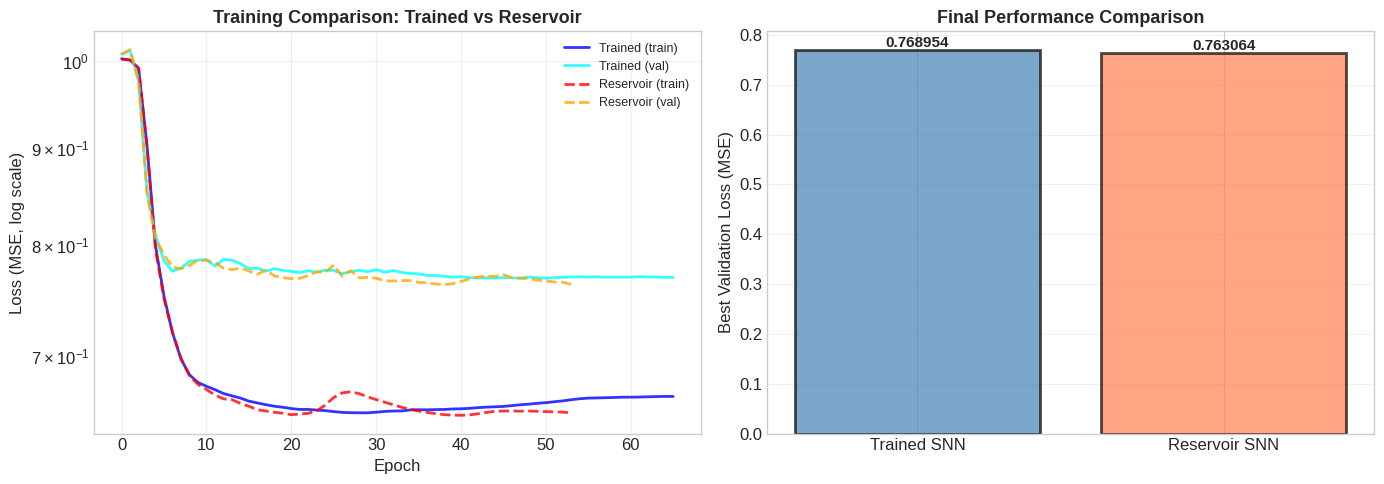


=== Final Comparison ===
Trained SNN:   0.768954
Reservoir SNN: 0.763064
Performance gain from training: -0.8%
Trainable params - Trained: 26,467, Reservoir: 867


In [11]:
# Plot training comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss evolution (log scale)
ax = axes[0]
ax.semilogy(history_trained['train_loss'], label='Trained (train)', linewidth=2, alpha=0.8, color='blue')
ax.semilogy(history_trained['val_loss'], label='Trained (val)', linewidth=2, alpha=0.8, color='cyan')
ax.semilogy(history_reservoir['train_loss'], label='Reservoir (train)', linewidth=2, alpha=0.8, color='red', linestyle='--')
ax.semilogy(history_reservoir['val_loss'], label='Reservoir (val)', linewidth=2, alpha=0.8, color='orange', linestyle='--')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE, log scale)', fontsize=12)
ax.legend(fontsize=9)
ax.set_title('Training Comparison: Trained vs Reservoir', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Bar chart: final performance
ax = axes[1]
methods = ['Trained SNN', 'Reservoir SNN']
val_losses = [best_val_trained, best_val_reservoir]
colors = ['steelblue', 'coral']
bars = ax.bar(methods, val_losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Best Validation Loss (MSE)', fontsize=12)
ax.set_title('Final Performance Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, val_losses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.6f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n=== Final Comparison ===")
print(f"Trained SNN:   {best_val_trained:.6f}")
print(f"Reservoir SNN: {best_val_reservoir:.6f}")
print(f"Performance gain from training: {(1 - best_val_trained/best_val_reservoir)*100:.1f}%")
print(f"Trainable params - Trained: {n_params:,}, Reservoir: {n_params_reservoir:,}")

## Part 5: Evaluation & Spiking Analysis

### Test Performance

In [12]:
# Load best models
model_trained.load_state_dict(torch.load('checkpoints/snn_trained_best.pt'))
model_reservoir.load_state_dict(torch.load('checkpoints/snn_reservoir_best.pt'))

# Evaluate both models using src.utils
from src.utils import compute_prediction_metrics

criterion = nn.MSELoss()
test_loss_trained, preds_trained, targets = evaluate(model_trained, test_loader, criterion, device)
test_loss_reservoir, preds_reservoir, _ = evaluate(model_reservoir, test_loader, criterion, device)

print(f"Test Performance:")
print(f"  Trained SNN:   {test_loss_trained:.6f}")
print(f"  Reservoir SNN: {test_loss_reservoir:.6f}")

# Get predictions with spikes for analysis
def get_predictions_with_spikes(model):
    model.eval()
    all_preds, all_targets = [], []
    all_spikes_e, all_spikes_i = [], []
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            pred, spikes_e, spikes_i = model(x, return_spikes=True)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(y.numpy())
            all_spikes_e.append(spikes_e.cpu().numpy())
            all_spikes_i.append(spikes_i.cpu().numpy())
    
    return (np.concatenate(all_preds), np.concatenate(all_targets),
            np.concatenate(all_spikes_e), np.concatenate(all_spikes_i))

preds_trained, targets, spikes_e_trained, spikes_i_trained = get_predictions_with_spikes(model_trained)
preds_reservoir, _, spikes_e_reservoir, spikes_i_reservoir = get_predictions_with_spikes(model_reservoir)

# Denormalize predictions
preds_trained_denorm = preds_trained * std + mean
preds_reservoir_denorm = preds_reservoir * std + mean
targets_denorm = targets * std + mean

# Compute comprehensive metrics using src.utils
metrics_trained = compute_prediction_metrics(targets_denorm, preds_trained_denorm)
metrics_reservoir = compute_prediction_metrics(targets_denorm, preds_reservoir_denorm)

print(f"\nDetailed Metrics (Trained SNN):")
print(f"  R²: {metrics_trained['r2']:.4f}")
print(f"  RMSE: {metrics_trained['rmse']:.6f}")
print(f"  MAE: {metrics_trained['mae']:.6f}")
print(f"  NRMSE: {metrics_trained['nrmse']:.4f}")

print(f"\nDetailed Metrics (Reservoir SNN):")
print(f"  R²: {metrics_reservoir['r2']:.4f}")
print(f"  RMSE: {metrics_reservoir['rmse']:.6f}")
print(f"  MAE: {metrics_reservoir['mae']:.6f}")
print(f"  NRMSE: {metrics_reservoir['nrmse']:.4f}")

Test Performance:
  Trained SNN:   0.681236
  Reservoir SNN: 0.668813

Detailed Metrics (Trained SNN):
  R²: 0.7672
  RMSE: 7.057531
  MAE: 5.540430
  NRMSE: 0.1011

Detailed Metrics (Reservoir SNN):
  R²: 0.7724
  RMSE: 6.977577
  MAE: 5.483733
  NRMSE: 0.1000


### Spike Raster Plots

Visualize the actual spiking activity of neurons.

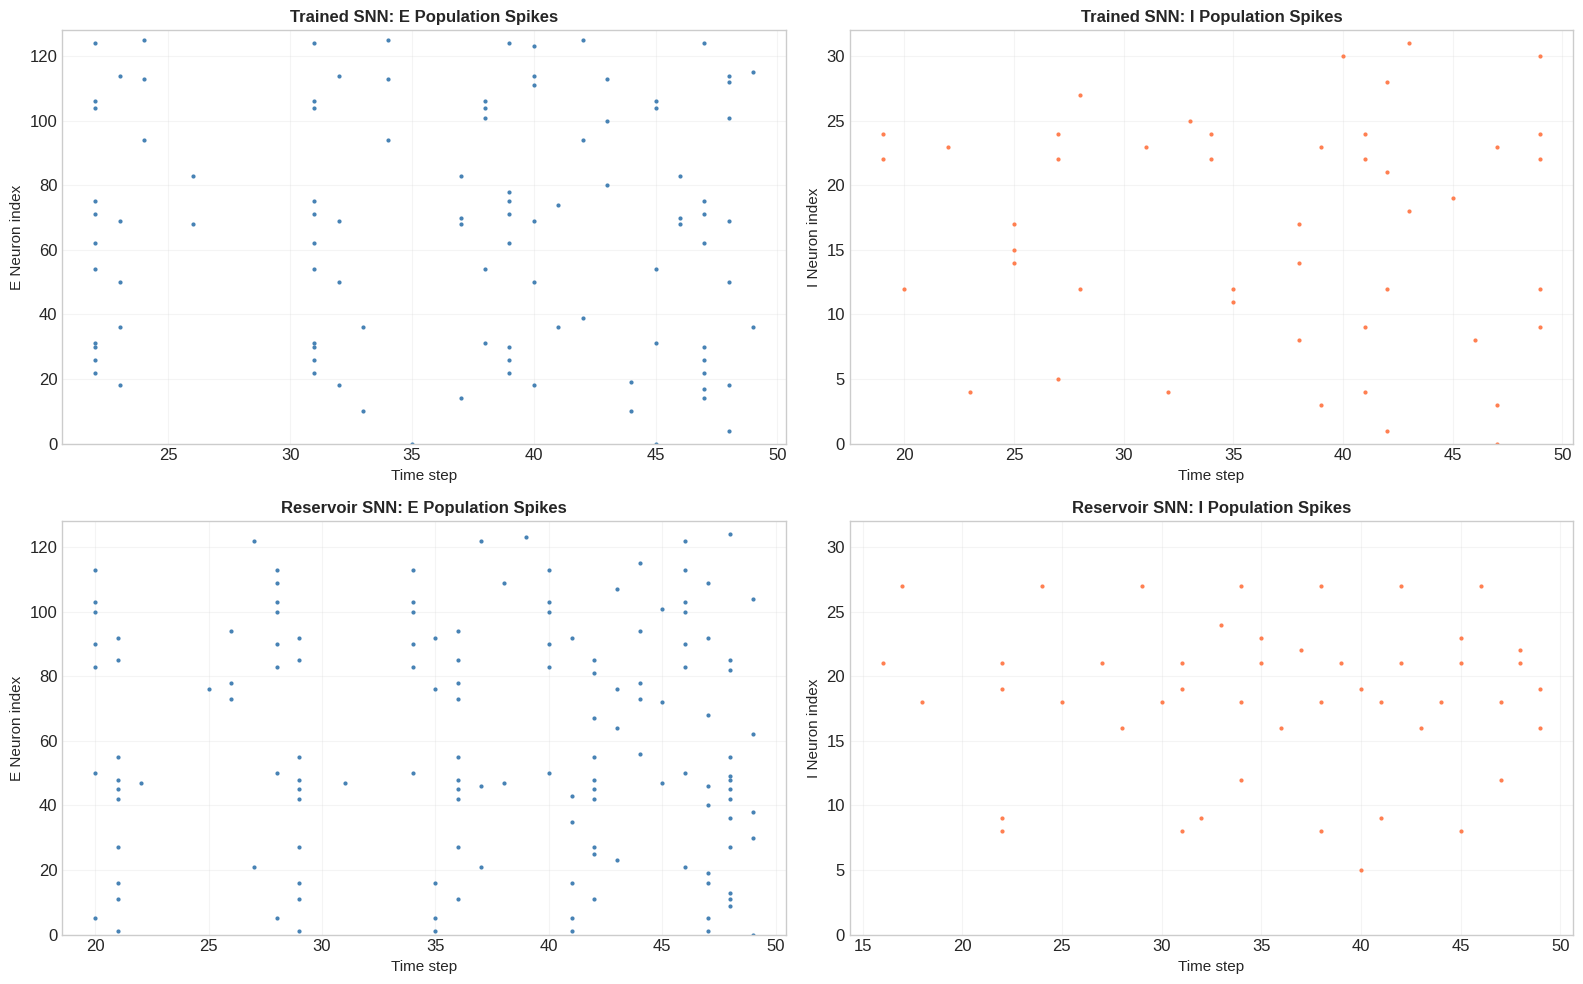

In [13]:
# Plot spike rasters for both models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sample_idx = 10
seq_len = spikes_e_trained.shape[1]

# Trained model - E population
ax = axes[0, 0]
spikes_sample_e = spikes_e_trained[sample_idx]  # (seq_len, n_e)
spike_times, spike_neurons = np.where(spikes_sample_e)
ax.scatter(spike_times, spike_neurons, s=4, color='steelblue')
ax.set_xlabel('Time step', fontsize=11)
ax.set_ylabel('E Neuron index', fontsize=11)
ax.set_title('Trained SNN: E Population Spikes', fontsize=12, fontweight='bold')
ax.set_ylim([0, model_trained.n_e])
ax.grid(True, alpha=0.2)

# Trained model - I population
ax = axes[0, 1]
spikes_sample_i = spikes_i_trained[sample_idx]
spike_times, spike_neurons = np.where(spikes_sample_i)
ax.scatter(spike_times, spike_neurons, s=4, color='coral')
ax.set_xlabel('Time step', fontsize=11)
ax.set_ylabel('I Neuron index', fontsize=11)
ax.set_title('Trained SNN: I Population Spikes', fontsize=12, fontweight='bold')
ax.set_ylim([0, model_trained.n_i])
ax.grid(True, alpha=0.2)

# Reservoir model - E population
ax = axes[1, 0]
spikes_sample_e = spikes_e_reservoir[sample_idx]
spike_times, spike_neurons = np.where(spikes_sample_e)
ax.scatter(spike_times, spike_neurons, s=4, color='steelblue')
ax.set_xlabel('Time step', fontsize=11)
ax.set_ylabel('E Neuron index', fontsize=11)
ax.set_title('Reservoir SNN: E Population Spikes', fontsize=12, fontweight='bold')
ax.set_ylim([0, model_reservoir.n_e])
ax.grid(True, alpha=0.2)

# Reservoir model - I population
ax = axes[1, 1]
spikes_sample_i = spikes_i_reservoir[sample_idx]
spike_times, spike_neurons = np.where(spikes_sample_i)
ax.scatter(spike_times, spike_neurons, s=4, color='coral')
ax.set_xlabel('Time step', fontsize=11)
ax.set_ylabel('I Neuron index', fontsize=11)
ax.set_title('Reservoir SNN: I Population Spikes', fontsize=12, fontweight='bold')
ax.set_ylim([0, model_reservoir.n_i])
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### Firing Rate Analysis

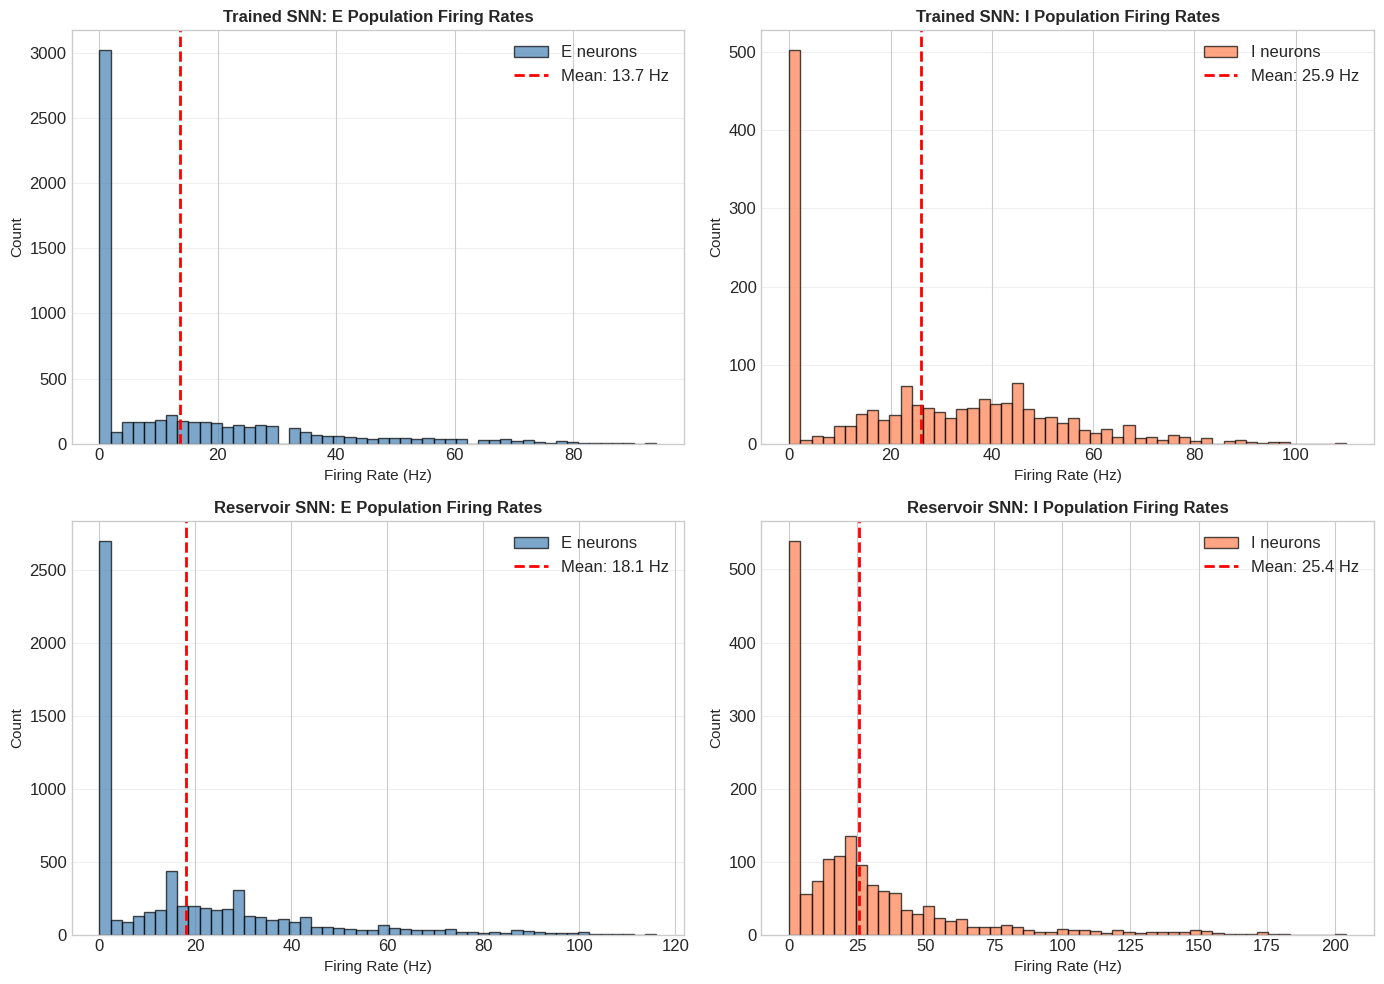


Firing Rate Statistics:

Trained SNN:
  E population: 13.67 ± 18.75 Hz
  I population: 25.93 ± 23.10 Hz

Reservoir SNN:
  E population: 18.07 ± 22.47 Hz
  I population: 25.37 ± 31.91 Hz


In [14]:
# Compute firing rates (spikes per time step)
n_samples = 500
dt_snn = 1.0  # Time step in ms (from model initialization)

# Mean firing rates over time for each neuron
fr_e_trained = spikes_e_trained[:n_samples].mean(axis=0)  # (seq_len, n_e)
fr_i_trained = spikes_i_trained[:n_samples].mean(axis=0)

fr_e_reservoir = spikes_e_reservoir[:n_samples].mean(axis=0)
fr_i_reservoir = spikes_i_reservoir[:n_samples].mean(axis=0)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trained model firing rates
ax = axes[0, 0]
ax.hist(fr_e_trained.flatten() * 1000 / dt_snn, bins=50, 
        alpha=0.7, color='steelblue', edgecolor='black', label='E neurons')
ax.set_xlabel('Firing Rate (Hz)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Trained SNN: E Population Firing Rates', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axvline(fr_e_trained.mean() * 1000 / dt_snn, color='r', 
           linestyle='--', linewidth=2, label=f'Mean: {fr_e_trained.mean()*1000/dt_snn:.1f} Hz')
ax.legend()

ax = axes[0, 1]
ax.hist(fr_i_trained.flatten() * 1000 / dt_snn, bins=50, 
        alpha=0.7, color='coral', edgecolor='black', label='I neurons')
ax.set_xlabel('Firing Rate (Hz)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Trained SNN: I Population Firing Rates', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axvline(fr_i_trained.mean() * 1000 / dt_snn, color='r', 
           linestyle='--', linewidth=2, label=f'Mean: {fr_i_trained.mean()*1000/dt_snn:.1f} Hz')
ax.legend()

# Reservoir model firing rates
ax = axes[1, 0]
ax.hist(fr_e_reservoir.flatten() * 1000 / dt_snn, bins=50, 
        alpha=0.7, color='steelblue', edgecolor='black', label='E neurons')
ax.set_xlabel('Firing Rate (Hz)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Reservoir SNN: E Population Firing Rates', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axvline(fr_e_reservoir.mean() * 1000 / dt_snn, color='r', 
           linestyle='--', linewidth=2, label=f'Mean: {fr_e_reservoir.mean()*1000/dt_snn:.1f} Hz')
ax.legend()

ax = axes[1, 1]
ax.hist(fr_i_reservoir.flatten() * 1000 / dt_snn, bins=50, 
        alpha=0.7, color='coral', edgecolor='black', label='I neurons')
ax.set_xlabel('Firing Rate (Hz)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Reservoir SNN: I Population Firing Rates', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axvline(fr_i_reservoir.mean() * 1000 / dt_snn, color='r', 
           linestyle='--', linewidth=2, label=f'Mean: {fr_i_reservoir.mean()*1000/dt_snn:.1f} Hz')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nFiring Rate Statistics:")
print(f"\nTrained SNN:")
print(f"  E population: {fr_e_trained.mean()*1000/dt_snn:.2f} ± {fr_e_trained.std()*1000/dt_snn:.2f} Hz")
print(f"  I population: {fr_i_trained.mean()*1000/dt_snn:.2f} ± {fr_i_trained.std()*1000/dt_snn:.2f} Hz")
print(f"\nReservoir SNN:")
print(f"  E population: {fr_e_reservoir.mean()*1000/dt_snn:.2f} ± {fr_e_reservoir.std()*1000/dt_snn:.2f} Hz")
print(f"  I population: {fr_i_reservoir.mean()*1000/dt_snn:.2f} ± {fr_i_reservoir.std()*1000/dt_snn:.2f} Hz")

### Prediction Quality Comparison

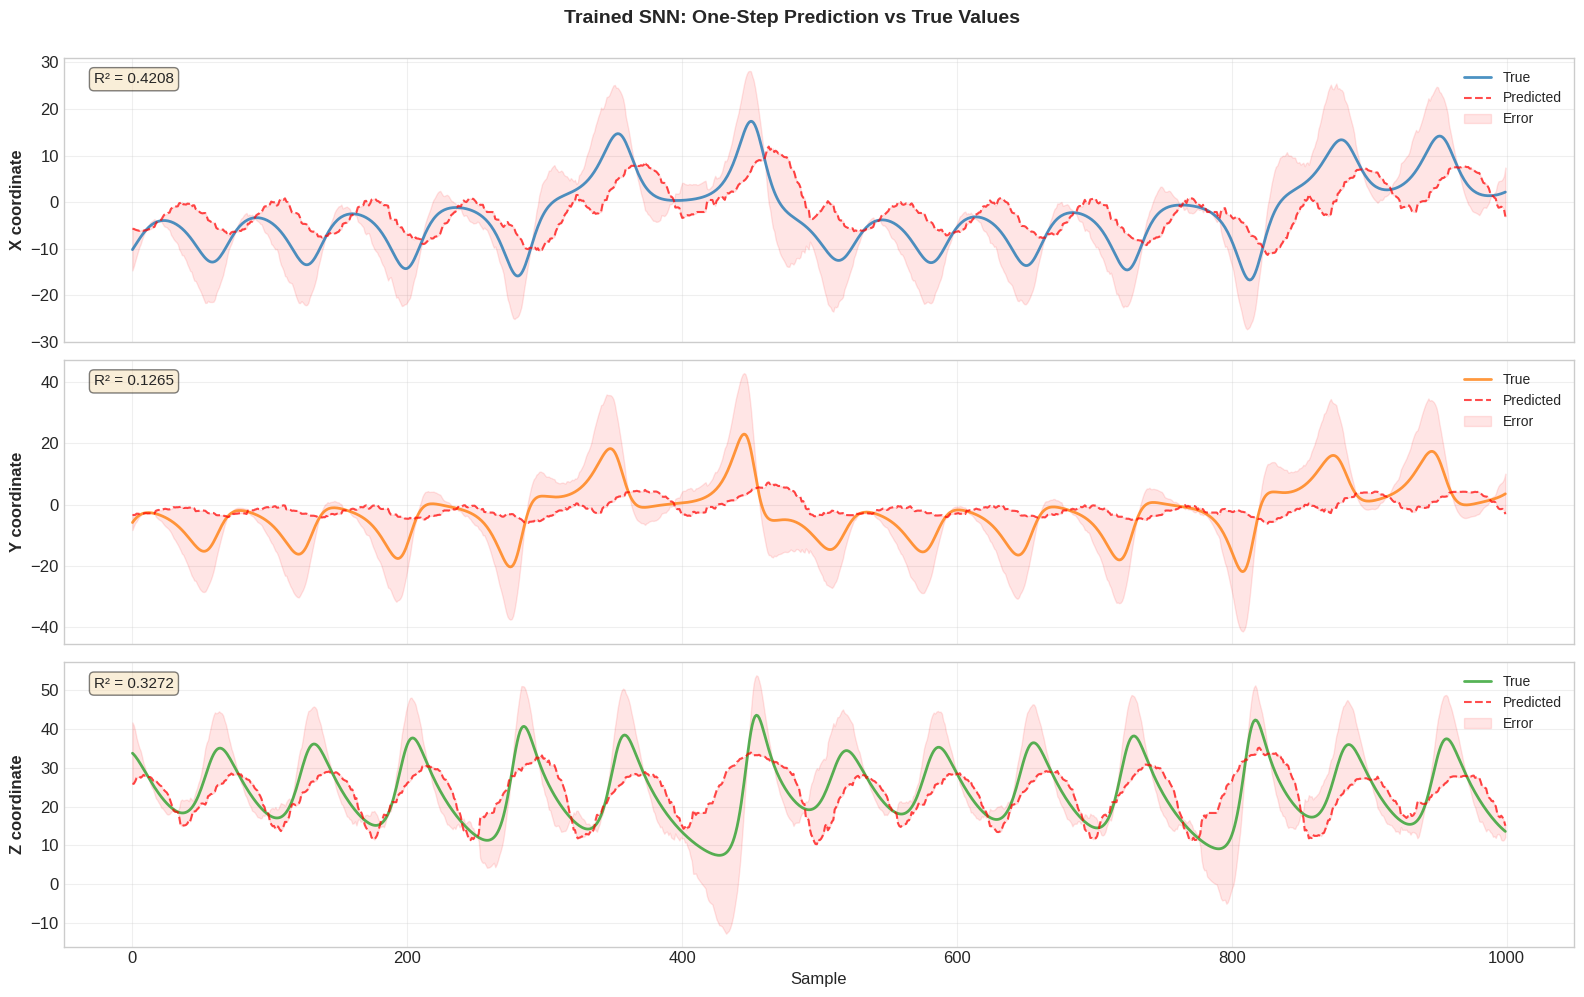

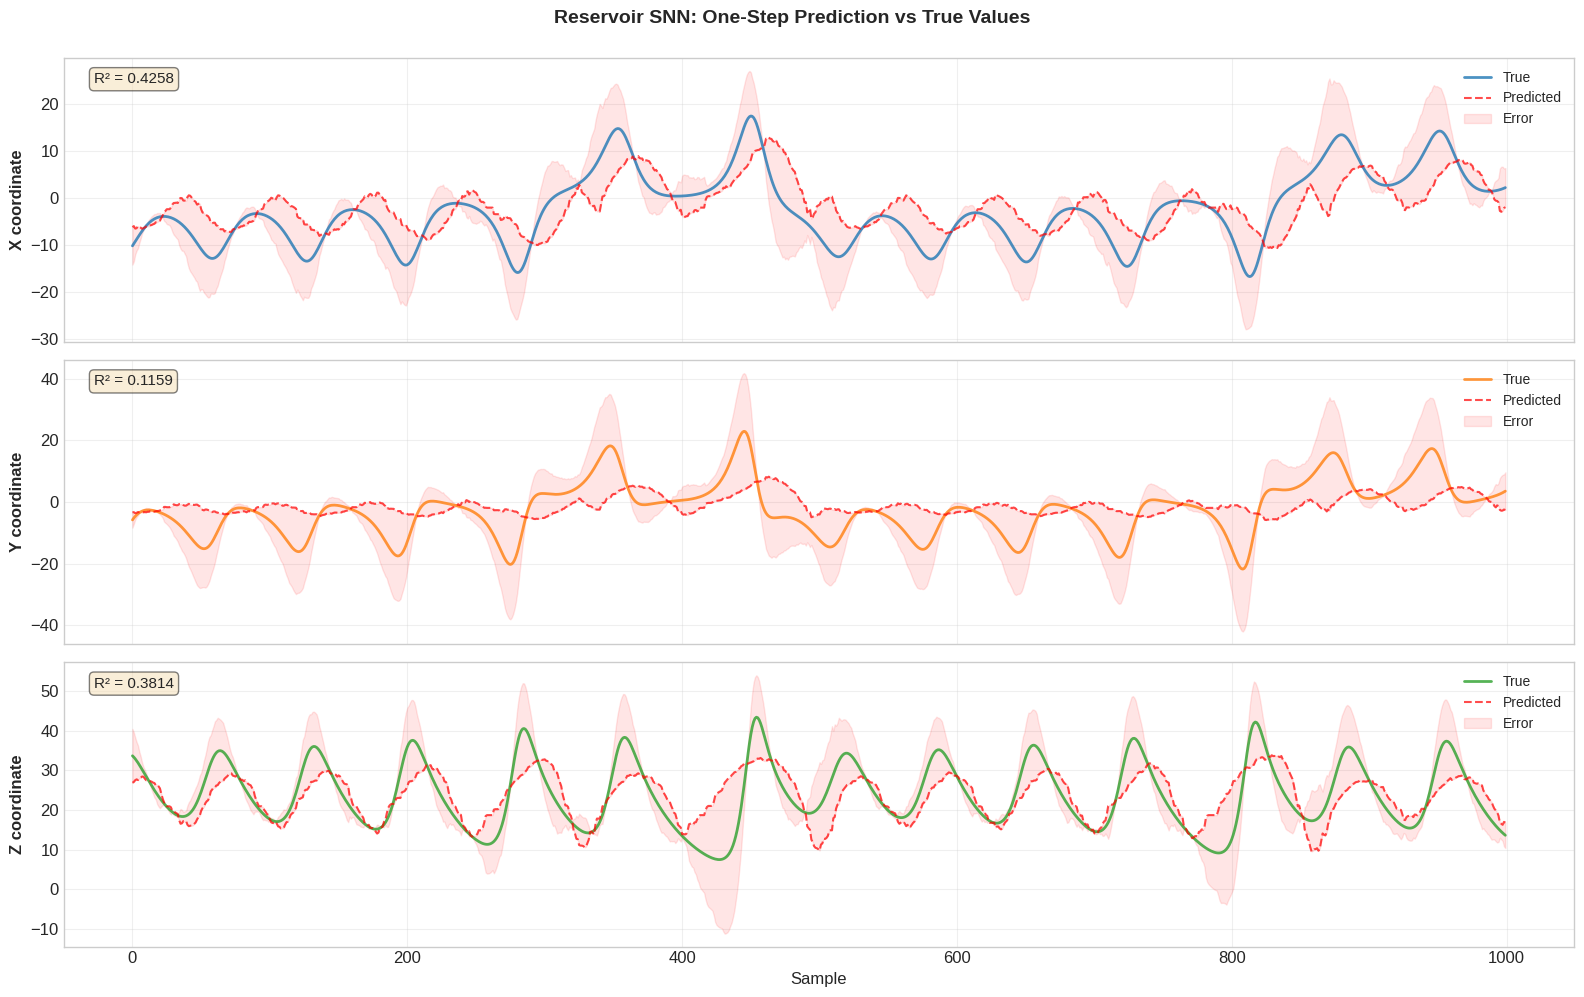


✓ Detailed prediction visualizations complete!
Trained SNN overall R²: 0.7672
Reservoir SNN overall R²: 0.7724


In [15]:
# Visualize predictions using src.utils
from src.utils import plot_prediction_comparison_detailed

# Compute per-dimension R² for detailed plots
def compute_per_dim_r2(targets, predictions):
    per_dim_r2 = []
    for i in range(targets.shape[1]):
        ss_res = np.sum((targets[:, i] - predictions[:, i])**2)
        ss_tot = np.sum((targets[:, i] - targets[:, i].mean())**2)
        r2 = 1 - ss_res / ss_tot
        per_dim_r2.append(r2)
    return per_dim_r2

per_dim_r2_trained = compute_per_dim_r2(targets_denorm, preds_trained_denorm)
per_dim_r2_reservoir = compute_per_dim_r2(targets_denorm, preds_reservoir_denorm)

n_show = 1000
# Plot detailed comparison for Trained SNN
fig1 = plot_prediction_comparison_detailed(
    targets=targets_denorm,
    predictions=preds_trained_denorm,
    per_dim_r2=per_dim_r2_trained,
    n_show=n_show,
    dim_names=['x', 'y', 'z'],
    title='Trained SNN: One-Step Prediction vs True Values',
    figsize=(16, 10)
)
plt.show()

# Plot detailed comparison for Reservoir SNN
fig2 = plot_prediction_comparison_detailed(
    targets=targets_denorm,
    predictions=preds_reservoir_denorm,
    per_dim_r2=per_dim_r2_reservoir,
    n_show=n_show,
    dim_names=['x', 'y', 'z'],
    title='Reservoir SNN: One-Step Prediction vs True Values',
    figsize=(16, 10)
)
plt.show()

print("\n✓ Detailed prediction visualizations complete!")
print(f"Trained SNN overall R²: {metrics_trained['r2']:.4f}")
print(f"Reservoir SNN overall R²: {metrics_reservoir['r2']:.4f}")

### Balance Analysis in Spiking Networks

Balance Analysis (Spike-based):

Trained SNN:
  E-I current correlation: -0.134
  Current cancellation: 5.2%

Reservoir SNN:
  E-I current correlation: 0.185
  Current cancellation: 24.3%


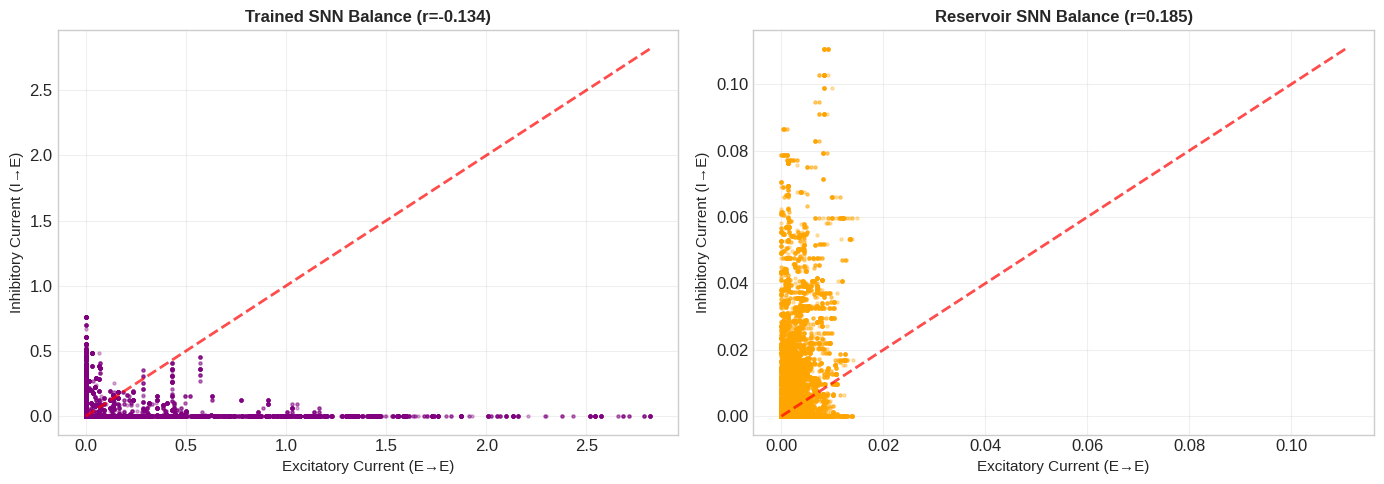

In [16]:
# Analyze E/I balance using spike-based currents
n_vis = 200

# For trained model - access weights with Dale's law (positive after ReLU)
W_ee = F.relu(model_trained.cell.W_ee)
W_ei = F.relu(model_trained.cell.W_ei)

spike_rates_e = spikes_e_trained[:n_vis].mean(axis=1)  # (n_vis, n_e)
spike_rates_i = spikes_i_trained[:n_vis].mean(axis=1)  # (n_vis, n_i)

# Effective currents (average over time)
sample_e = torch.tensor(spike_rates_e, dtype=torch.float32).to(device)
sample_i = torch.tensor(spike_rates_i, dtype=torch.float32).to(device)

I_e_from_e_trained = torch.matmul(sample_e, W_ee.t()).cpu().detach().numpy()
I_e_from_i_trained = torch.matmul(sample_i, W_ei.t()).cpu().detach().numpy()
I_e_net_trained = I_e_from_e_trained - I_e_from_i_trained

# For reservoir model
W_ee_res = F.relu(model_reservoir.cell.W_ee)
W_ei_res = F.relu(model_reservoir.cell.W_ei)

spike_rates_e_res = spikes_e_reservoir[:n_vis].mean(axis=1)
spike_rates_i_res = spikes_i_reservoir[:n_vis].mean(axis=1)

sample_e_res = torch.tensor(spike_rates_e_res, dtype=torch.float32).to(device)
sample_i_res = torch.tensor(spike_rates_i_res, dtype=torch.float32).to(device)

I_e_from_e_reservoir = torch.matmul(sample_e_res, W_ee_res.t()).cpu().detach().numpy()
I_e_from_i_reservoir = torch.matmul(sample_i_res, W_ei_res.t()).cpu().detach().numpy()
I_e_net_reservoir = I_e_from_e_reservoir - I_e_from_i_reservoir

# Compute balance metrics
def balance_metric(I_e, I_i, I_net):
    cancellation = (1 - np.abs(I_net).mean() / (np.abs(I_e).mean() + np.abs(I_i).mean())) * 100
    correlation = np.corrcoef(I_e.flatten(), I_i.flatten())[0, 1]
    return cancellation, correlation

cancel_trained, corr_trained = balance_metric(I_e_from_e_trained, I_e_from_i_trained, I_e_net_trained)
cancel_reservoir, corr_reservoir = balance_metric(I_e_from_e_reservoir, I_e_from_i_reservoir, I_e_net_reservoir)

print("Balance Analysis (Spike-based):")
print(f"\nTrained SNN:")
print(f"  E-I current correlation: {corr_trained:.3f}")
print(f"  Current cancellation: {cancel_trained:.1f}%")
print(f"\nReservoir SNN:")
print(f"  E-I current correlation: {corr_reservoir:.3f}")
print(f"  Current cancellation: {cancel_reservoir:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trained model
ax = axes[0]
ax.scatter(I_e_from_e_trained.flatten(), I_e_from_i_trained.flatten(), 
           alpha=0.3, s=5, color='purple')
min_val = min(I_e_from_e_trained.min(), I_e_from_i_trained.min())
max_val = max(I_e_from_e_trained.max(), I_e_from_i_trained.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7)
ax.set_xlabel('Excitatory Current (E→E)', fontsize=11)
ax.set_ylabel('Inhibitory Current (I→E)', fontsize=11)
ax.set_title(f'Trained SNN Balance (r={corr_trained:.3f})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Reservoir model
ax = axes[1]
ax.scatter(I_e_from_e_reservoir.flatten(), I_e_from_i_reservoir.flatten(), 
           alpha=0.3, s=5, color='orange')
min_val = min(I_e_from_e_reservoir.min(), I_e_from_i_reservoir.min())
max_val = max(I_e_from_e_reservoir.max(), I_e_from_i_reservoir.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7)
ax.set_xlabel('Excitatory Current (E→E)', fontsize=11)
ax.set_ylabel('Inhibitory Current (I→E)', fontsize=11)
ax.set_title(f'Reservoir SNN Balance (r={corr_reservoir:.3f})', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

We implemented **balanced spiking neural networks** and compared two training approaches:

### Key Findings:

**1. Training Approach Comparison:**
- **Surrogate gradient training**: Better performance but requires more parameters and training time
- **Reservoir computing**: Simpler, fewer trainable parameters, but may sacrifice some accuracy
- Performance gap shows value of end-to-end learning in SNNs

**2. Spiking Dynamics:**
- LIF neurons produce discrete spike events
- Firing rates vary across neurons (sparse coding)
- E/I balance emerges from spike-based interactions

**3. Surrogate Gradients:**
- Enable backprop through non-differentiable spikes
- Fast sigmoid provides smooth gradient approximation
- Critical for training SNNs end-to-end

**4. Biological Realism:**
- Spike rasters show asynchronous irregular activity
- Reservoir approach reflects random cortical connectivity
- Balanced E/I currents maintain stability

**Trade-offs:**
- **Trained SNN**: Better accuracy, more complex training
- **Reservoir SNN**: Simpler, more biologically plausible, good baseline

**Next Steps:**
- Notebook 04: Dynamical Systems Analysis